In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)
def reset_random_seeds(seeds):
   os.environ['PYTHONHASHSEED']=str(2)
   set_seed(seeds)
   np.random.seed(2022)
   random.seed(2022)

import random
import pandas as pd
import numpy as np
import itertools

from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose

!pip install 'xgboost>=1.6'
from xgboost import XGBRegressor

from sklearn.metrics import r2_score as r2score
from sklearn.metrics import mean_squared_log_error as rmsle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredLogarithmicError as msle
from tensorflow.keras.models import load_model

!pip install lightgbm
from lightgbm import LGBMRegressor

from tqdm import tqdm

!pip install fbprophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 35 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.6 MB/s 
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
    Running setup.py install for fbprophet ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokeni

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/GIT_AI


In [3]:
archive = ZipFile('DATA/store-sales-time-series-forecasting.zip', 'r')

In [4]:
archive.namelist()

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [5]:
train = pd.read_csv(archive.open("train.csv"))
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [6]:
test = pd.read_csv(archive.open("test.csv"))
test.head(10)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


In [7]:
oil = pd.read_csv(archive.open("oil.csv"))
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
holidays = pd.read_csv(archive.open("holidays_events.csv"))
holidays.head(22)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [9]:
stores = pd.read_csv(archive.open("stores.csv"))
stores.sample(10)

,store_nbr,city,state,type,cluster
34,35,Playas,Guayas,C,3
30,31,Babahoyo,Los Rios,B,10
53,54,El Carmen,Manabi,C,3
52,53,Manta,Manabi,D,13
24,25,Salinas,Santa Elena,D,1
20,21,Santo Domingo,Santo Domingo de los Tsachilas,B,6
47,48,Quito,Pichincha,A,14
38,39,Cuenca,Azuay,B,6
28,29,Guayaquil,Guayas,E,10
12,13,Latacunga,Cotopaxi,C,15


In [10]:
transactions = pd.read_csv(archive.open("transactions.csv"))
transactions.head(15)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [11]:
archive.close()

# Data preparation

In [12]:
train.isnull().values.any()

False

## Joining information from other tables

**Replacing NaN value**

In [13]:
oil['dcoilwtico'].iloc[0] = oil['dcoilwtico'].iloc[1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
train = pd.merge(train, oil, on = "date", how = 'left')
test = pd.merge(test, oil, on = "date", how = 'left')

In [15]:
train.iloc[7125:7130]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
7125,7125,2013-01-04,9,PRODUCE,0.0,0,93.12
7126,7126,2013-01-04,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,93.12
7127,7127,2013-01-04,9,SEAFOOD,11.0,0,93.12
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,NaN
7129,7129,2013-01-05,1,BABY CARE,0.0,0,NaN


In [16]:
train.fillna(method='ffill', inplace=True)

In [17]:
train.iloc[7125:7130]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
7125,7125,2013-01-04,9,PRODUCE,0.0,0,93.12
7126,7126,2013-01-04,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,93.12
7127,7127,2013-01-04,9,SEAFOOD,11.0,0,93.12
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,93.12
7129,7129,2013-01-05,1,BABY CARE,0.0,0,93.12


In [18]:
test.fillna(method='ffill', inplace=True)

In [19]:
holidays.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [20]:
holidays['locale'] = holidays['locale'].map({'Local': 1, 'Regional': 2, 'National': 3})
holidays = holidays[holidays.transferred == False]
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,1,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,2,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,1,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,1,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,1,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,3,Ecuador,Navidad-3,False
346,2017-12-23,Additional,3,Ecuador,Navidad-2,False
347,2017-12-24,Additional,3,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,3,Ecuador,Navidad,False


In [21]:
holidays = holidays[['date', 'locale']]
holidays.rename(columns={"locale": "holiday"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
train = pd.merge(train, holidays, on = "date", how = 'left')
test = pd.merge(test, holidays, on = "date", how = 'left')

In [23]:
train[train['date'] == '2013-11-02'].iloc[:10]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
550638,543510,2013-11-02,1,AUTOMOTIVE,4.000,0,94.56,3.0
550639,543511,2013-11-02,1,BABY CARE,0.000,0,94.56,3.0
550640,543512,2013-11-02,1,BEAUTY,2.000,0,94.56,3.0
550641,543513,2013-11-02,1,BEVERAGES,1030.000,0,94.56,3.0
550642,543514,2013-11-02,1,BOOKS,0.000,0,94.56,3.0
550643,543515,2013-11-02,1,BREAD/BAKERY,254.201,0,94.56,3.0
550644,543516,2013-11-02,1,CELEBRATION,0.000,0,94.56,3.0
550645,543517,2013-11-02,1,CLEANING,497.000,0,94.56,3.0
550646,543518,2013-11-02,1,DAIRY,419.000,0,94.56,3.0
550647,543519,2013-11-02,1,DELI,103.303,0,94.56,3.0


In [24]:
train[train['date'] == '2013-11-05'].iloc[:10]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
555984,548856,2013-11-05,1,AUTOMOTIVE,1.000,0,93.4,NaN
555985,548857,2013-11-05,1,BABY CARE,0.000,0,93.4,NaN
555986,548858,2013-11-05,1,BEAUTY,1.000,0,93.4,NaN
555987,548859,2013-11-05,1,BEVERAGES,853.000,0,93.4,NaN
555988,548860,2013-11-05,1,BOOKS,0.000,0,93.4,NaN
555989,548861,2013-11-05,1,BREAD/BAKERY,294.910,0,93.4,NaN
555990,548862,2013-11-05,1,CELEBRATION,0.000,0,93.4,NaN
555991,548863,2013-11-05,1,CLEANING,853.000,0,93.4,NaN
555992,548864,2013-11-05,1,DAIRY,591.000,0,93.4,NaN
555993,548865,2013-11-05,1,DELI,125.776,0,93.4,NaN


In [25]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [26]:
train[train['date'] == '2013-11-05'].iloc[:10]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
555984,548856,2013-11-05,1,AUTOMOTIVE,1.000,0,93.4,0.0
555985,548857,2013-11-05,1,BABY CARE,0.000,0,93.4,0.0
555986,548858,2013-11-05,1,BEAUTY,1.000,0,93.4,0.0
555987,548859,2013-11-05,1,BEVERAGES,853.000,0,93.4,0.0
555988,548860,2013-11-05,1,BOOKS,0.000,0,93.4,0.0
555989,548861,2013-11-05,1,BREAD/BAKERY,294.910,0,93.4,0.0
555990,548862,2013-11-05,1,CELEBRATION,0.000,0,93.4,0.0
555991,548863,2013-11-05,1,CLEANING,853.000,0,93.4,0.0
555992,548864,2013-11-05,1,DAIRY,591.000,0,93.4,0.0
555993,548865,2013-11-05,1,DELI,125.776,0,93.4,0.0


In [27]:
train = pd.merge(train, transactions, on = ['date', 'store_nbr'], how = 'left')
test = pd.merge(test, transactions, on = ['date', 'store_nbr'], how = 'left')

In [28]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [29]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

In [30]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [31]:
train.isnull().values.any()

False

In [ ]:
test.isnull().values.any()

False

## EDA

In [ ]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
family_mean = train[['family', 'sales']].groupby('family').mean().sort_values(by='sales', ascending=False).reset_index()

In [ ]:
px.bar(family_mean, x="family", y="sales")

In [ ]:
family_mean['sales'] = family_mean['sales']*100/sum(family_mean['sales'])

In [ ]:
family_mapper = family_mean.set_index('family').T.to_dict(orient='index')['sales']

In [ ]:
train['family'] = train['family'].map(family_mapper)
test['family'] = test['family'].map(family_mapper)

In [ ]:
train.sample(10)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions
id,,,,,,,,
2654983,2017-02-02,53,0.000942,0.000,0,53.55,0.0,1009.0
435055,2013-09-02,16,0.141943,0.000,0,107.98,0.0,1096.0
2863013,2017-05-30,4,0.187095,28.487,0,49.63,0.0,1179.0
360703,2013-07-22,3,0.182839,47.000,0,106.61,0.0,2903.0
656919,2014-01-05,40,0.060606,0.000,0,93.66,0.0,1132.0
2159953,2016-04-30,14,0.000596,0.000,0,45.98,3.0,1738.0
349006,2013-07-15,50,0.025030,0.000,0,106.20,0.0,2398.0
2882025,2017-06-10,24,20.214175,4602.000,21,45.82,0.0,2164.0
1225705,2014-11-20,5,0.060966,2.000,0,75.63,0.0,1341.0


In [ ]:
store_mean = train[['store_nbr', 'sales']].groupby('store_nbr').mean().sort_values(by='sales', ascending=False).reset_index()
px.bar(store_mean, x="store_nbr", y="sales")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   store_nbr     int64         
 2   family        float64       
 3   sales         float64       
 4   onpromotion   int64         
 5   dcoilwtico    float64       
 6   holiday       float64       
 7   transactions  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 209.7 MB


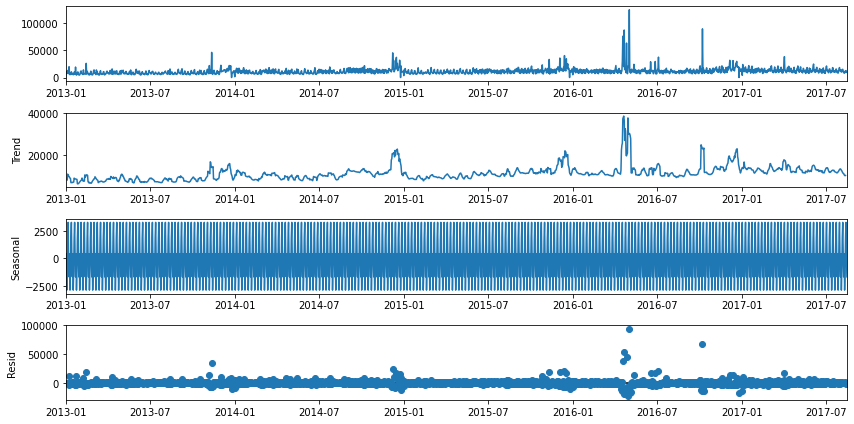

In [ ]:
sd = seasonal_decompose(train[['date', 'sales']].groupby('date').max().asfreq('d').fillna(0), model='add')
fig = sd.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()

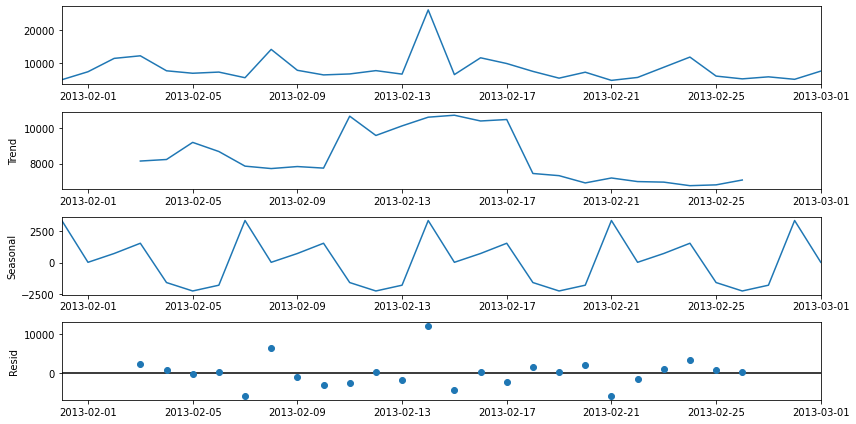

In [ ]:
sd = seasonal_decompose(train[['date', 'sales']].groupby('date').max().asfreq('d').fillna(0).iloc[30:60], model='add')
fig = sd.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()

**`sales` seasonality is 7 days**

# XGBoost

In [ ]:
train_multi_idx = train.set_index([train.index, 'date'])

In [ ]:
X = train_multi_idx.drop(columns=['sales'])
y = train_multi_idx['sales']

Number of store as percent of mean sales.

In [ ]:
store_mean['sales'] = store_mean['sales']*100/sum(store_mean['sales'])

In [ ]:
store_mapper = store_mean.set_index('store_nbr').T.to_dict(orient='index')['sales']

In [ ]:
X['store_nbr'] = X['store_nbr'].map(store_mapper)

80:20 train-test split

In [ ]:
X_train, X_test = X[:-int(len(y)*0.2)], X[-int(len(y)*0.2):]
y_train, y_test = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [ ]:
simple_xgb = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", eval_metric='rmsle')
simple_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=1)

[0]	validation_0-rmsle:1.41536
[1]	validation_0-rmsle:1.14460
[2]	validation_0-rmsle:1.07493
[3]	validation_0-rmsle:1.02706
[4]	validation_0-rmsle:1.04141
[5]	validation_0-rmsle:1.04439
[6]	validation_0-rmsle:nan
[7]	validation_0-rmsle:nan
[8]	validation_0-rmsle:nan
[9]	validation_0-rmsle:nan
[10]	validation_0-rmsle:nan
[11]	validation_0-rmsle:nan
[12]	validation_0-rmsle:nan
[13]	validation_0-rmsle:nan
[14]	validation_0-rmsle:nan
[15]	validation_0-rmsle:nan
[16]	validation_0-rmsle:nan
[17]	validation_0-rmsle:nan
[18]	validation_0-rmsle:nan
[19]	validation_0-rmsle:nan
[20]	validation_0-rmsle:nan
[21]	validation_0-rmsle:nan
[22]	validation_0-rmsle:nan
[23]	validation_0-rmsle:nan
[24]	validation_0-rmsle:nan
[25]	validation_0-rmsle:nan
[26]	validation_0-rmsle:nan
[27]	validation_0-rmsle:nan
[28]	validation_0-rmsle:nan
[29]	validation_0-rmsle:nan
[30]	validation_0-rmsle:nan
[31]	validation_0-rmsle:nan
[32]	validation_0-rmsle:nan
[33]	validation_0-rmsle:nan
[34]	validation_0-rmsle:nan
[35]	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
pred = simple_xgb.predict(X_test)
r2score(pred, y_test)

0.8963287746125947

Date as parameter, not index

In [ ]:
train_date_param = train.drop(columns=['date'])
dates = pd.DatetimeIndex(train['date'])

train_date_param['year'] = dates.year
train_date_param['months'] = dates.month
train_date_param['days'] = dates.day
train_date_param.sample(10)

,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions,year,months,days
id,,,,,,,,,,
1782259,16,2.963268,76.87400,0,45.06,0.0,748.0,2015,9,30
1789034,7,3.917647,747.39197,2,45.54,0.0,1840.0,2015,10,3
2227328,53,0.033341,5.00000,0,49.71,0.0,1408.0,2016,6,6
367387,17,0.025030,0.00000,0,104.76,0.0,1099.0,2013,7,26
2704480,41,0.025030,0.00000,0,52.63,1.0,1039.0,2017,3,2
2399278,29,0.182839,8.00000,2,45.88,0.0,1364.0,2016,9,11
672603,30,11.439983,772.22650,0,92.15,0.0,750.0,2014,1,14
2076807,30,1.496434,109.00000,0,37.20,0.0,718.0,2016,3,14
2832181,25,0.723815,327.00000,5,47.83,3.0,1059.0,2017,5,13


In [ ]:
X = train_date_param.drop(columns=['sales'])
y = train_date_param['sales']
X['store_nbr'] = X['store_nbr'].map(store_mapper)
X_train, X_test = X[:-int(len(y)*0.2)], X[-int(len(y)*0.2):]
y_train, y_test = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [ ]:
date_xgb = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", eval_metric='rmsle')

date_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = date_xgb.predict(X_test)
r2score(y_test, pred)

0.9259372184363099

In [ ]:
#lr=0.1 -> worse
#n_est=1000 -> 0.001 better
date_xgb2 = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", eval_metric='rmsle', learning_rate=0.15, n_jobs=-1)

date_xgb2.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = date_xgb2.predict(X_test)
r2score(y_test, pred)

0.9243567071815184

In [ ]:
final_xgb = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", learning_rate=0.3, n_jobs=-1)
final_xgb.fit(X, y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
test_date_param = test.drop(columns='date')
dates = pd.DatetimeIndex(test['date'])

test_date_param['year'] = dates.year
test_date_param['months'] = dates.month
test_date_param['days'] = dates.day
test_date_param.sample(10)

,store_nbr,family,onpromotion,dcoilwtico,holiday,transactions,year,months,days
id,,,,,,,,,
3023532,44,0.071085,0,46.40,0.0,0.0,2017,8,28
3029323,7,0.723815,2,47.26,0.0,0.0,2017,8,31
3005616,41,2.242038,52,48.59,0.0,0.0,2017,8,18
3025020,36,2.242038,8,46.46,0.0,0.0,2017,8,29
3013096,50,0.025030,13,47.65,0.0,0.0,2017,8,22
3027211,47,0.723815,2,45.96,0.0,0.0,2017,8,30
3006618,2,0.060606,1,48.59,0.0,0.0,2017,8,19
3006791,24,0.817703,0,48.59,0.0,0.0,2017,8,19
3024880,32,0.000942,0,46.46,0.0,0.0,2017,8,29


In [ ]:
xgb_pred = date_xgb.predict(test_date_param)

In [ ]:
xgb_test = test.copy()
xgb_test['sales'] = xgb_pred

In [ ]:
xgb_test.sales.to_csv('final_xgb.csv')

In [ ]:
# import joblib
# joblib.dump(final_xgb,'final_xgb.joblib')

['final_xgb.joblib']

# Simple RNN

In [ ]:
train.store_nbr.nunique()

54

In [ ]:
#SCALER
train_multi_idx = train.set_index([train.index, 'date'])
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(train_multi_idx['sales']))

MinMaxScaler()

In [ ]:
def data_split(data, store_num, scaler):
    
    X = data.groupby("store_nbr").get_group(store_num)['sales'] 

    X = pd.DataFrame(X)

    X_train, X_test = X.iloc[:-int(len(X)*0.2)], X.iloc[-int(len(X)*0.2):]

    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    
    return scaled_train, scaled_test
 

#RNN MODEL
def rnn_model():
    reset_random_seeds(2022)

    # define model
    model = Sequential()

    # Simple RNN layer
    model.add(SimpleRNN(64, input_shape=(length, 1)))

    # Final Prediction
    model.add(Dense(1))

    model.compile(optimizer='adam', loss=msle())
    
    return model        

In [ ]:
length = 7 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
early_stop = EarlyStopping(monitor='val_loss', patience=2)
store_number = train_multi_idx.store_nbr.unique()

for i in store_number:
    scaled_train, scaled_test = data_split(train_multi_idx, store_num=i, scaler=scaler)
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
    test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)
    rnn_model().fit(generator, epochs=10, 
                validation_data=test_generator, 
                callbacks=[early_stop]) 
    rnn_model().save(f'simpleRNN_store_{i}.h5')
print("Training completed")

Training completed


**Checking model performance for store 11**

In [ ]:
model = load_model('simpleRNN_store_11.h5')

In [ ]:
length = 7 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch

In [ ]:
scaled_train, scaled_test = data_split(train_multi_idx, store_num=11, scaler=scaler)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [ ]:
test_pred = scaler.inverse_transform(model.predict(test_generator))

11305/11305 [==============================] - 26s 2ms/step


In [ ]:
X = train_multi_idx.groupby("store_nbr").get_group(11)['sales'] 

X = pd.DataFrame(X)

X_train, X_test = X.iloc[:-int(len(X)*0.2)], X.iloc[-int(len(X)*0.2):]

In [ ]:
predict = X_test.copy()
predict = predict.iloc[length-6:-6]
predict.columns = ['actual']
predict['predicted'] = -test_pred

In [ ]:
alpha = np.max(predict.predicted)/np.max(predict.actual)

In [ ]:
predict['predicted'] = -test_pred/alpha

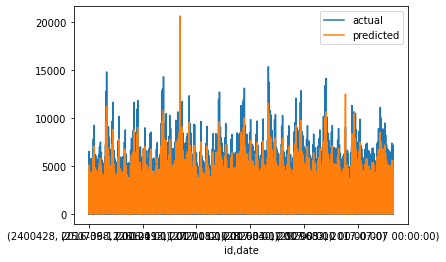

In [ ]:
predict.plot()

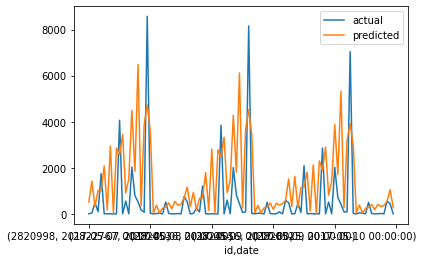

In [ ]:
predict.iloc[-3400:-3300].plot()

In [ ]:
r2score(predict['actual'], predict['predicted'])

-0.48188517661030494

In [ ]:
forecast = []

periods = len(test[test.store_nbr == 11])

data = scaled_test.copy()

for i in range(periods):
  eval_batch = data[-length:]
  current_batch = eval_batch.reshape((1, length, 1))   
  current_pred = model.predict(current_batch, verbose=0)[0]/(-alpha)
  forecast.append(current_pred) 
  data = np.append(data, current_pred[0])

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
test_multi_idx = test.set_index([test.index, 'date'])

In [ ]:
forecast_df = pd.DataFrame(data=forecast, index=test_multi_idx[test_multi_idx.store_nbr == 11].index, columns=['Forecast'])

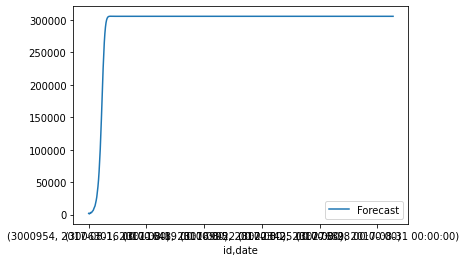

In [ ]:
forecast_df.plot()

**Forecasting for simple RNN model looks poor even after additional scaling**

#RNN with more features



In [ ]:
#SCALER
train_multi_idx = train.set_index([train.index, 'date'])
scaler = StandardScaler()
scaler.fit(pd.DataFrame(train_multi_idx))

StandardScaler()

In [ ]:
# data for 11th store
data = train_multi_idx.groupby("store_nbr").get_group(11) 
# scaling and droping store nbr column
X = np.delete(scaler.transform(data), [0, 2], axis=1)
y = scaler.transform(data)[:, 2]
# split
X_train, X_test = X[:-int(len(data)*0.2)], X[-int(len(data)*0.2):]
y_train, y_test = y[:-int(len(data)*0.2)], y[-int(len(data)*0.2):]

In [ ]:
def rnn_model():
    reset_random_seeds(2022)

    # define model
    model = Sequential()

    # Simple RNN layer
    model.add(SimpleRNN(100, input_shape=(length, 5)))

    # Final Prediction
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    
    return model   

def lstm_model():
    reset_random_seeds(2022)

    # define model
    model = Sequential()

    # Simple RNN layer
    model.add(LSTM(100, input_shape=(length, 5)))

    # Final Prediction
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    
    return model   

In [ ]:
length = 7 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
early_stop = EarlyStopping(monitor='val_loss', patience=2)
store_number = train_multi_idx.store_nbr.unique()

generator = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)

In [ ]:
rnn_model().fit(generator, epochs=10, validation_data=test_generator, callbacks=[early_stop]) 
rnn_model().save(f'RNN_store_11.h5')

Epoch 1/10
45243/45243 [==============================] - 236s 5ms/step - loss: 0.3450 - val_loss: 0.4264
Epoch 2/10
45243/45243 [==============================] - 241s 5ms/step - loss: 0.2299 - val_loss: 0.3316
Epoch 3/10
45243/45243 [==============================] - 191s 4ms/step - loss: 0.2034 - val_loss: 0.4496
Epoch 4/10
45243/45243 [==============================] - 188s 4ms/step - loss: 0.1994 - val_loss: 0.3162
Epoch 5/10
45243/45243 [==============================] - 188s 4ms/step - loss: 0.2023 - val_loss: 0.4512
Epoch 6/10
45243/45243 [==============================] - 189s 4ms/step - loss: 0.2067 - val_loss: 0.4586


In [ ]:
lstm_model().fit(generator, epochs=10, validation_data=test_generator, callbacks=[early_stop]) 
lstm_model().save(f'LSTM_store_11.h5')

Epoch 1/10
45243/45243 [==============================] - 298s 7ms/step - loss: 0.2936 - val_loss: 0.2770
Epoch 2/10
45243/45243 [==============================] - 293s 6ms/step - loss: 0.1429 - val_loss: 0.2048
Epoch 3/10
45243/45243 [==============================] - 289s 6ms/step - loss: 0.1341 - val_loss: 0.2055
Epoch 4/10
45243/45243 [==============================] - 311s 7ms/step - loss: 0.1253 - val_loss: 0.2362


**Models' evaluation**

In [ ]:
test_multi_idx = test.set_index([test.index, 'date'])
df = test_multi_idx.copy()
df.insert(2, "sales", [0]*len(test))
df = df[df.store_nbr == 11]
data = np.delete(scaler.transform(df), [0, 2], axis=1)
test_gen = TimeseriesGenerator(data, [0]*len(data), length=length, batch_size=batch_size)

In [ ]:
model = load_model('RNN_store_11.h5')

In [ ]:
preds = model.predict(test_generator, verbose=0)

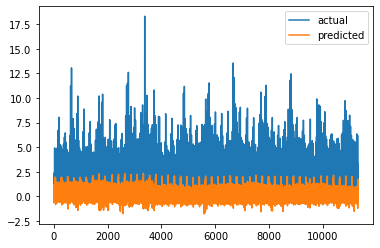

In [ ]:
eval_df = pd.DataFrame({'actual': y_test[7:], 'predicted': preds.T[0]})
eval_df.plot()

In [ ]:
r2score(eval_df['actual'], eval_df['predicted'])

-0.13640762187666944

In [ ]:
pred = model.predict(test_gen, verbose=0)

In [ ]:
forecast = scaler.transform(df)[length:]
forecast[:, 2] = pred.T 
forecast = scaler.inverse_transform(forecast)

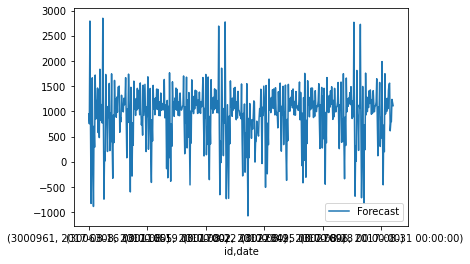

In [ ]:
forecast_df = pd.DataFrame(data=forecast[:, 2], index=df.index[length:], columns=['Forecast'])
forecast_df.plot()

**LSTM evaluation**

In [ ]:
model = load_model('LSTM_store_11.h5')

In [ ]:
preds = model.predict(test_generator, verbose=0)

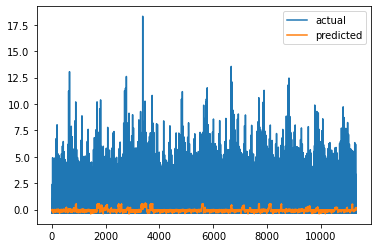

In [ ]:
eval_df = pd.DataFrame({'actual': y_test[7:], 'predicted': preds.T[0]})
eval_df.plot()

In [ ]:
r2score(eval_df['actual'], eval_df['predicted'])

-0.04745356912836307

In [ ]:
pred = model.predict(test_gen, verbose=0)

In [ ]:
forecast = scaler.transform(df)[length:]
forecast[:, 2] = pred.T 
forecast = scaler.inverse_transform(forecast)

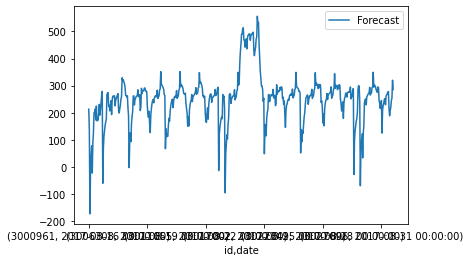

In [ ]:
forecast_df = pd.DataFrame(data=forecast[:, 2], index=df.index[length:], columns=['Forecast'])
forecast_df.plot()

**XGB comparison**

In [ ]:
xgb = pd.read_csv('final_xgb.csv')

In [ ]:
xgb

,id,sales
0,3000888,1.045846
1,3000889,1.950505
2,3000890,65.223140
3,3000891,4246.488000
4,3000892,1.950505
...,...,...
28507,3029395,247.711730
28508,3029396,10.177865
28509,3029397,955.976560
28510,3029398,352.702030


In [ ]:
xgb_11 = xgb.loc[xgb['id'].isin(test[test.store_nbr == 11].index)].reset_index()

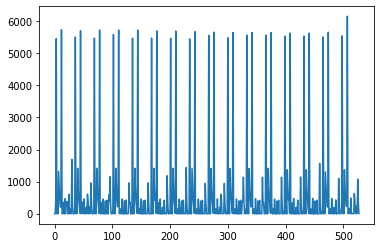

In [ ]:
xgb_11.sales.plot()

#Light GBM

In [ ]:
train_multi_idx = train.set_index([train.index, 'date'])

In [ ]:
X = train_multi_idx.drop(columns=['sales'])
y = train_multi_idx['sales']

Number of store as percent of mean sales.

In [ ]:
store_mean['sales'] = store_mean['sales']*100/sum(store_mean['sales'])

In [ ]:
store_mapper = store_mean.set_index('store_nbr').T.to_dict(orient='index')['sales']

In [ ]:
X['store_nbr'] = X['store_nbr'].map(store_mapper)

80:20 train-test split

In [ ]:
X_train, X_test = X[:-int(len(y)*0.2)], X[-int(len(y)*0.2):]
y_train, y_test = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [ ]:
simple_lgb = LGBMRegressor(n_estimators=200, max_depth=5, eval_metric='rmsle')
simple_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=1)

[1]	valid_0's l2: 1.63664e+06
[2]	valid_0's l2: 1.4274e+06
[3]	valid_0's l2: 1.24938e+06
[4]	valid_0's l2: 1.10074e+06
[5]	valid_0's l2: 967364
[6]	valid_0's l2: 860463
[7]	valid_0's l2: 771610
[8]	valid_0's l2: 692686
[9]	valid_0's l2: 629619
[10]	valid_0's l2: 570915
[11]	valid_0's l2: 524270
[12]	valid_0's l2: 481978
[13]	valid_0's l2: 448774
[14]	valid_0's l2: 418425
[15]	valid_0's l2: 394744
[16]	valid_0's l2: 372126
[17]	valid_0's l2: 350968
[18]	valid_0's l2: 334709
[19]	valid_0's l2: 321142
[20]	valid_0's l2: 311276
[21]	valid_0's l2: 299251
[22]	valid_0's l2: 289700
[23]	valid_0's l2: 280844
[24]	valid_0's l2: 270298
[25]	valid_0's l2: 260510
[26]	valid_0's l2: 254116
[27]	valid_0's l2: 246098
[28]	valid_0's l2: 241376
[29]	valid_0's l2: 236813
[30]	valid_0's l2: 231488
[31]	valid_0's l2: 228361
[32]	valid_0's l2: 225108
[33]	valid_0's l2: 220951
[34]	valid_0's l2: 217752
[35]	valid_0's l2: 214726
[36]	valid_0's l2: 212577
[37]	valid_0's l2: 209906
[38]	valid_0's l2: 208225
[3

LGBMRegressor(eval_metric='rmsle', max_depth=5, n_estimators=200)

In [ ]:
pred = simple_lgb.predict(X_test)
r2score(pred, y_test)

0.8807907173940057

In [ ]:
simple_lgb = LGBMRegressor(n_estimators=1000, max_depth=5)
simple_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

LGBMRegressor(max_depth=5, n_estimators=1000)

In [ ]:
pred = simple_lgb.predict(X_test)
r2score(pred, y_test)

0.8936481083629433

Date as parameter, not index

In [ ]:
train_date_param = train.drop(columns=['date'])
dates = pd.DatetimeIndex(train['date'])

train_date_param['year'] = dates.year
train_date_param['months'] = dates.month
train_date_param['days'] = dates.day

In [ ]:
X = train_date_param.drop(columns=['sales'])
y = train_date_param['sales']
X['store_nbr'] = X['store_nbr'].map(store_mapper)
X_train, X_test = X[:-int(len(y)*0.2)], X[-int(len(y)*0.2):]
y_train, y_test = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [ ]:
date_lgb = LGBMRegressor(n_estimators=1000, max_depth=5)

date_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = date_lgb.predict(X_test)
r2score(y_test, pred)

0.9292255892908795

In [ ]:
#lr=0.01 -> worse
date_lgb2 = LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.15)

date_lgb2.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = date_lgb2.predict(X_test)
r2score(y_test, pred)

0.9265985351100995

In [ ]:
tuned_parameters = {
                 'max_depth': [3, 5, 9],
                 'learning_rate': [0.05, 0.1, 0.2]}

lgb_model =LGBMRegressor(n_estimators=1000)

model_lgb = GridSearchCV(lgb_model, tuned_parameters, cv=5, scoring='r2')
model_lgb.fit(X_train, y_train)

print(model_lgb.best_score_)
print(model_lgb.best_params_)

0.8525595871070836
{'learning_rate': 0.1, 'max_depth': 5}


In [ ]:
final_lgb = LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)
final_lgb.fit(X, y, verbose=False)

LGBMRegressor(max_depth=5, n_estimators=1000)

In [ ]:
test_date_param = test.drop(columns='date')
test_date_param['store_nbr'] = test_date_param['store_nbr'].map(store_mapper)
dates = pd.DatetimeIndex(test['date'])
test_date_param['year'] = dates.year
test_date_param['months'] = dates.month
test_date_param['days'] = dates.day
test_date_param.sample(10)

,store_nbr,family,onpromotion,dcoilwtico,holiday,transactions,year,months,days
id,,,,,,,,,
3017447,1.083923,0.033341,0,47.65,0.0,0.0,2017,8,25
3016177,1.755300,1.448255,0,47.24,1.0,0.0,2017,8,24
3021144,1.787636,0.052626,0,47.65,0.0,0.0,2017,8,27
3018604,2.345557,2.963268,40,47.65,0.0,0.0,2017,8,25
3021584,1.760499,3.917647,11,47.65,0.0,0.0,2017,8,27
3022105,1.054347,0.025030,0,47.65,0.0,0.0,2017,8,27
3019072,2.008699,0.000942,0,47.65,0.0,0.0,2017,8,26
3018391,1.450369,0.182839,0,47.65,0.0,0.0,2017,8,25
3020991,1.083923,0.071085,0,47.65,0.0,0.0,2017,8,27


In [ ]:
lgb_pred = date_lgb.predict(test_date_param)
#lgb_pred[lgb_pred < 0] = 0
lgb_test = test.copy()
lgb_test['sales'] = lgb_pred
lgb_test.sales.to_csv('final_lgb.csv')
# import joblib
# joblib.dump(final_lgb,'final_lgb.joblib')

## Training time series for stores and families separately

Preview of several time series

In [ ]:
train_11_produce = train[(train.store_nbr == 11) & (train.family == 'PRODUCE')]
train_11_produce.tail(10)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions
id,,,,,,,,
2983164,2017-08-06,11,PRODUCE,1539.230,9,49.57,0.0,2430.0
2984946,2017-08-07,11,PRODUCE,1349.253,8,49.37,0.0,2322.0
2986728,2017-08-08,11,PRODUCE,2253.195,140,49.07,0.0,2285.0
2988510,2017-08-09,11,PRODUCE,1082.373,9,49.59,0.0,2306.0
2990292,2017-08-10,11,PRODUCE,1467.928,8,48.54,0.0,2176.0
2992074,2017-08-11,11,PRODUCE,1449.669,8,48.81,3.0,2254.0
2993856,2017-08-12,11,PRODUCE,1280.458,8,48.81,0.0,2230.0
2995638,2017-08-13,11,PRODUCE,1290.197,8,48.81,0.0,2101.0
2997420,2017-08-14,11,PRODUCE,1239.467,8,47.59,0.0,2203.0


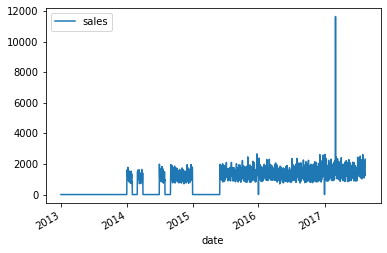

In [ ]:
train_11_produce[['date', 'sales']].set_index('date').plot()

In [ ]:
len(train_11_produce)

1714

In [ ]:
train_11_produce.date.nunique()

1684

In [ ]:
train_52_seafood = train[(train.store_nbr == 52) & (train.family == 'SEAFOOD')]
train_52_seafood.tail(10)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions
id,,,,,,,,
2984651,2017-08-06,52,SEAFOOD,3.959,0,49.57,0.0,2711.0
2986433,2017-08-07,52,SEAFOOD,13.000,0,49.37,0.0,2152.0
2988215,2017-08-08,52,SEAFOOD,3.000,0,49.07,0.0,1997.0
2989997,2017-08-09,52,SEAFOOD,8.000,0,49.59,0.0,2300.0
2991779,2017-08-10,52,SEAFOOD,9.000,0,48.54,0.0,2165.0
2993561,2017-08-11,52,SEAFOOD,23.000,3,48.81,3.0,2957.0
2995343,2017-08-12,52,SEAFOOD,5.000,0,48.81,0.0,2804.0
2997125,2017-08-13,52,SEAFOOD,12.000,0,48.81,0.0,2433.0
2998907,2017-08-14,52,SEAFOOD,6.595,0,47.59,0.0,2074.0


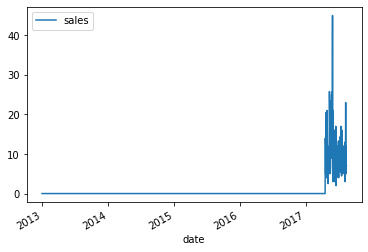

In [ ]:
train_52_seafood[['date', 'sales']].set_index('date').plot()

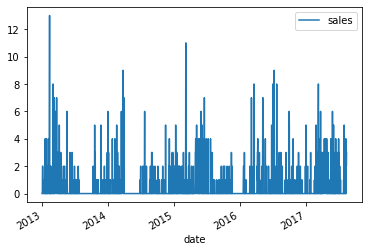

In [ ]:
train_35_seafood = train[(train.store_nbr == 35) & (train.family == 'SEAFOOD')]
train_35_seafood[['date', 'sales']].set_index('date').plot()

Test training for 11th store and family 'PRODUCE' - 7-days-lagged time series

In [ ]:
train_date_param = train_11_produce.drop(columns=['date', 'store_nbr', 'family'])
dates = pd.DatetimeIndex(train_11_produce['date'])
train_date_param['year'] = dates.year
train_date_param['months'] = dates.month
train_date_param['days'] = dates.day

In [ ]:
scaler_X = MinMaxScaler()
scaler_X.fit(train_date_param.drop(columns=['sales']))
scaler_y = MinMaxScaler()
scaler_y.fit(pd.DataFrame(train_date_param['sales']))

MinMaxScaler()

In [ ]:
scaled_X = scaler_X.transform(train_date_param.drop(columns=['sales']))
scaled_y = scaler_y.transform(pd.DataFrame(train_date_param['sales']))

In [ ]:
scaled_X_train, scaled_X_val = scaled_X[:-62], scaled_X[-62:]
scaled_y_train, scaled_y_val = scaled_y[:-62], scaled_y[-62:]

In [ ]:
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=7, batch_size=1)
val_generator = TimeseriesGenerator(scaled_X_val, scaled_y_val, length=7, batch_size=1)

In [ ]:
X_train = np.array([i[0].reshape(-1) for i in generator])
y_train = np.array([i[1][0] for i in generator]).T[0]
X_val = np.array([i[0].reshape(-1) for i in val_generator])
y_val = np.array([i[1][0] for i in val_generator]).T[0]

In [ ]:
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)

lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

pred = lgb.predict(X_val)
r2score(y_val, pred)

0.34139320833789744

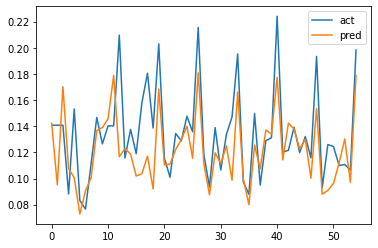

In [ ]:
pred_df = pd.DataFrame({'act': y_val, 'pred': pred})
pred_df.plot()

In [ ]:
rmsle(scaler_y.inverse_transform(y_val.reshape(-1, 1)), scaler_y.inverse_transform(pred.reshape(-1, 1)), squared=False)

0.2015324401314854

Test training for 11th store and family 'PRODUCE' - 14-days-lagged time series

In [ ]:
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=14, batch_size=1)
val_generator = TimeseriesGenerator(scaled_X_val, scaled_y_val, length=14, batch_size=1)

In [ ]:
X_train = np.array([i[0].reshape(-1) for i in generator])
y_train = np.array([i[1][0] for i in generator]).T[0]
X_val = np.array([i[0].reshape(-1) for i in val_generator])
y_val = np.array([i[1][0] for i in val_generator]).T[0]

In [ ]:
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)

lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

pred = lgb.predict(X_val)
r2score(y_val, pred)

0.38138029257133754

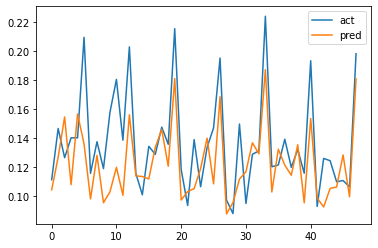

In [ ]:
pred_df = pd.DataFrame({'act': y_val, 'pred': pred})
pred_df.plot()

In [ ]:
rmsle(scaler_y.inverse_transform(y_val.reshape(-1, 1)), scaler_y.inverse_transform(pred.reshape(-1, 1)), squared=False)

0.19211032221187202

Test training for 11th store and family 'PRODUCE' - 30-days-lagged time series


In [ ]:
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=30, batch_size=1)
val_generator = TimeseriesGenerator(scaled_X_val, scaled_y_val, length=30, batch_size=1)

In [ ]:
X_train = np.array([i[0].reshape(-1) for i in generator])
y_train = np.array([i[1][0] for i in generator]).T[0]
X_val = np.array([i[0].reshape(-1) for i in val_generator])
y_val = np.array([i[1][0] for i in val_generator]).T[0]

In [ ]:
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)

lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

pred = lgb.predict(X_val)
r2score(y_val, pred)

0.5383722509931765

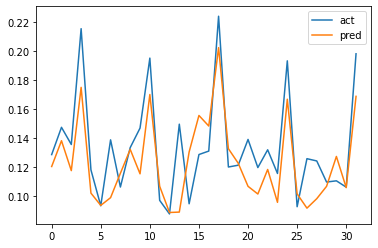

In [ ]:
pred_df = pd.DataFrame({'act': y_val, 'pred': pred})
pred_df.plot()

In [ ]:
rmsle(scaler_y.inverse_transform(y_val.reshape(-1, 1)), scaler_y.inverse_transform(pred.reshape(-1, 1)), squared=False)

0.18670876881392476

Test training for 11th store and family 'PRODUCE' - straightforward model 

In [ ]:
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)

lgb.fit(scaled_X_train, scaled_y_train.T[0], eval_set=[(scaled_X_val, scaled_y_val.T[0])], verbose=False)

pred = lgb.predict(scaled_X_val)
r2score(scaled_y_val, pred)

0.6083101888906817

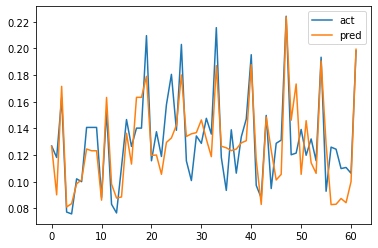

In [ ]:
pred_df = pd.DataFrame({'act': scaled_y_val.T[0], 'pred': pred})
pred_df.plot()

In [ ]:
rmsle(scaler_y.inverse_transform(scaled_y_val.T[0].reshape(-1, 1)), scaler_y.inverse_transform(pred.reshape(-1, 1)), squared=False)

0.17609494820508664

Test training for 11th store and family 'PRODUCE' - straightforward model without scaling

In [ ]:
X = train_date_param.drop(columns=['sales'])
y = pd.DataFrame(train_date_param['sales'])

X_train, X_val = X.iloc[:-62], X.iloc[-62:]
y_train, y_val = y.iloc[:-62], y.iloc[-62:]

In [ ]:
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)

lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

pred = lgb.predict(X_val)
r2score(y_val, pred)

In [ ]:
pred_df = pd.DataFrame({'act': y_val['sales'], 'pred': pred})
pred_df.plot()

In [ ]:
rmsle(y_val['sales'], pred, squared=False)

**Straightforward method without scaling is as good as time series method (regarding RMSLE), but is quicker and requaires less transformations.**

### (54 stores x 33 families) LGBM's trainings

In [53]:
train_dates = train.drop(columns=['date'])
dates = pd.DatetimeIndex(train['date'])
train_dates['year'] = dates.year
train_dates['months'] = dates.month
train_dates['days'] = dates.day

In [54]:
stores = train_dates.store_nbr.unique()
families = train_dates.family.unique()

In [55]:
SF_models = {}
errors = []

for store in tqdm(stores):
  F_models = {}

  for family in families:
    train_temp = train_dates[(train_dates.store_nbr == store) & (train_dates.family == family)]
    train_temp = train_temp.drop(columns=['store_nbr', 'family'])
    X = train_temp.drop(columns=['sales'])
    y = pd.DataFrame(train_temp['sales'])
    lgb = LGBMRegressor(n_estimators=1000, max_depth=5)
    lgb.fit(X, y, verbose=False)
    F_models[family] = lgb
    preds = lgb.predict(X.iloc[-16:])
    preds[preds < 0] = 0
    errors.append([store, family,
                   rmsle(y.iloc[-16:], preds, squared=False)])

  SF_models[store] = F_models

100%|██████████| 54/54 [22:51<00:00, 25.40s/it]


Forecasting

In [56]:
test_dates = test.drop(columns=['date'])
dates = pd.DatetimeIndex(test['date'])
test_dates['year'] = dates.year
test_dates['months'] = dates.month
test_dates['days'] = dates.day

In [57]:
len(test_dates)/54/33

16.0

In [58]:
forecast = test_dates.copy()
forecast['sales'] = 0

In [59]:
for store in tqdm(stores):
  for family in families:
    data = test_dates[(test_dates.store_nbr == store) & (test_dates.family == family)].values[:, 2:]
    preds = SF_models[store][family].predict(data)
    forecast.loc[(forecast.store_nbr == store) & (forecast.family == family), 'sales'] = preds

100%|██████████| 54/54 [00:15<00:00,  3.57it/s]


In [60]:
forecast

,store_nbr,family,onpromotion,dcoilwtico,holiday,transactions,year,months,days,sales
id,,,,,,,,,,
3000888,1,AUTOMOTIVE,0,46.80,0.0,0.0,2017,8,16,0.013797
3000889,1,BABY CARE,0,46.80,0.0,0.0,2017,8,16,0.000000
3000890,1,BEAUTY,2,46.80,0.0,0.0,2017,8,16,3.322130
3000891,1,BEVERAGES,20,46.80,0.0,0.0,2017,8,16,625.746904
3000892,1,BOOKS,0,46.80,0.0,0.0,2017,8,16,-0.010012
...,...,...,...,...,...,...,...,...,...,...
3029395,9,POULTRY,1,47.26,0.0,0.0,2017,8,31,278.087346
3029396,9,PREPARED FOODS,0,47.26,0.0,0.0,2017,8,31,78.336177
3029397,9,PRODUCE,1,47.26,0.0,0.0,2017,8,31,960.762408


Previews for 9 worst predicted time series

In [61]:
num_errors = [e[2] for e in errors]

In [ ]:
np.mean(num_errors)

0.16956434763073294

In [ ]:
np.max(num_errors)

3.085157674224522

In [ ]:
errors[np.argmax(num_errors)]

[39, 'MEATS', 3.085157674224522]

In [ ]:
sorted(num_errors)[-10:]

[0.6805596727335556,
 0.7184579861025779,
 0.7975557215759278,
 0.839901193046553,
 0.8686848065451318,
 0.8802555256442507,
 0.9642964075408105,
 0.9768467856036459,
 1.1439583196901448,
 3.085157674224522]

In [ ]:
errors[np.argsort(num_errors)[-2]][1]

'HOME AND KITCHEN I'

In [62]:
fig = make_subplots(rows=3, cols=3, subplot_titles=tuple(list('123456789')))
grid = list(itertools.product([1, 2, 3], repeat=2))
for i in range(1, 10):
  store = errors[np.argsort(num_errors)[-i]][0]
  family = errors[np.argsort(num_errors)[-i]][1]
  train_temp = train_dates[(train_dates.store_nbr == store) & (train_dates.family == family)]
   
  figure = px.line(train_temp.reset_index()['sales'])
  for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=grid[i-1][0], col=grid[i-1][1])
        fig.layout.annotations[i-1].update(text=f"{store}, {family}, error = {sorted(num_errors)[-i]:.2f}")  
fig.update_layout(showlegend=False)
fig.show()    

### Dealing with repeated dates

In [32]:
group_date = train[['date', 'sales']].groupby(["date"]).count()

In [ ]:
group_date.head(10)

,sales
date,
2013-01-01,1782
2013-01-02,1782
2013-01-03,1782
2013-01-04,1782
2013-01-05,1782
2013-01-06,1782
2013-01-07,1782
2013-01-08,1782
2013-01-09,1782


In [33]:
group_date.loc[group_date.sales > 33*54]

,sales
date,
2013-05-12,3564
2013-06-25,5346
2013-07-03,3564
2013-12-22,3564
2014-06-25,7128
2014-07-03,3564
2014-12-22,3564
2014-12-26,3564
2015-06-25,5346


In [34]:
test_date = train[train.date == '2013-05-12']
test_date

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions
id,,,,,,,,
233442,2013-05-12,1,AUTOMOTIVE,1.000,0,95.81,1.0,549.0
233442,2013-05-12,1,AUTOMOTIVE,1.000,0,95.81,3.0,549.0
233443,2013-05-12,1,BABY CARE,0.000,0,95.81,1.0,549.0
233443,2013-05-12,1,BABY CARE,0.000,0,95.81,3.0,549.0
233444,2013-05-12,1,BEAUTY,0.000,0,95.81,1.0,549.0
...,...,...,...,...,...,...,...,...
235221,2013-05-12,9,PRODUCE,0.000,0,95.81,3.0,2337.0
235222,2013-05-12,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,95.81,1.0,2337.0
235222,2013-05-12,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,95.81,3.0,2337.0


Dates are repeated due to overlapped holidays. In these cases, maximum values of holidays are kept. 

In [35]:
test_date.groupby(["date", "store_nbr", "family"]).max().reset_index()  

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,transactions
0,2013-05-12,1,AUTOMOTIVE,1.000,0,95.81,3.0,549.0
1,2013-05-12,1,BABY CARE,0.000,0,95.81,3.0,549.0
2,2013-05-12,1,BEAUTY,0.000,0,95.81,3.0,549.0
3,2013-05-12,1,BEVERAGES,384.000,0,95.81,3.0,549.0
4,2013-05-12,1,BOOKS,0.000,0,95.81,3.0,549.0
...,...,...,...,...,...,...,...,...
1777,2013-05-12,54,POULTRY,48.711,0,95.81,3.0,1350.0
1778,2013-05-12,54,PREPARED FOODS,70.000,0,95.81,3.0,1350.0
1779,2013-05-12,54,PRODUCE,0.000,0,95.81,3.0,1350.0
1780,2013-05-12,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,95.81,3.0,1350.0


In [36]:
train_wo_duplicates = train.groupby(["date", "store_nbr", "family"]).max().reset_index() 

### Dealing with outliers

In [ ]:
#https://neptune.ai/blog/anomaly-detection-in-time-series

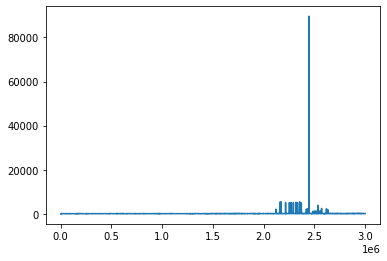

In [110]:
train_39_meats = train_wo_duplicates[(train_wo_duplicates.store_nbr == 39) & (train_wo_duplicates.family == 'MEATS')]
train_39_meats.sales.plot()

In [ ]:
# sd = seasonal_decompose(train_39_meats[['date', 'sales']].groupby('date').max().asfreq('d').fillna(0), model='add')
# fig = sd.plot()
# fig.set_size_inches((12, 6))
# # Tight layout to realign things
# fig.tight_layout()
# x = sd.resid.index
# y = sd.resid.values
# px.line(x=x, y=y, title = "residuals")

In [111]:
def fit_predict_model(dataframe):
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
               seasonality_mode = 'additive',
               interval_width = 0.99,
               changepoint_range = 0.8)
   m = m.fit(data)
   forecast = m.predict(data)
   forecast['actual'] = data['y'].reset_index(drop = True)
   return m, forecast

def detect_anomalies(forecast):
   forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'actual']].copy()
   forecasted['anomaly'] = 0
   forecasted.loc[forecasted['actual'] > forecasted['yhat_upper'], 'anomaly'] = -1
   forecasted.loc[forecasted['actual'] < forecasted['yhat_lower'], 'anomaly'] = -1
   return forecasted

In [112]:
data = train_39_meats[['date', 'sales']]
data.rename(columns={'date': "ds", 'sales': "y"}, inplace=True)
m, outliers = fit_predict_model(data)
outliers = detect_anomalies(outliers)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
outliers[outliers.anomaly != 0]

,ds,trend,yhat,yhat_lower,yhat_upper,actual,anomaly
1372,2016-10-07,702.784752,702.784752,-4767.080978,6061.854326,89576.36,-1


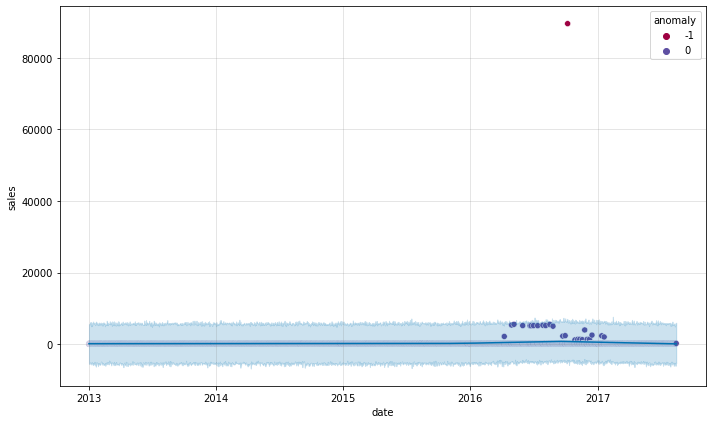

In [120]:
fig = plt.figure(facecolor='w', figsize=(10, 6))

ax = fig.add_subplot(111)

sns.scatterplot(data=outliers, x='ds', y='actual', hue='anomaly', palette="Spectral", ax=ax)
#ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.')
ax.plot(outliers.ds, outliers['yhat'], ls='-', c='#0072B2')
ax.fill_between(outliers.ds, outliers['yhat_lower'], outliers['yhat_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('sales')
fig.tight_layout()

Replacing outliers with `yhat`

In [121]:
train_39_meats.loc[(outliers.anomaly != 0).values, 'sales'] = outliers.loc[outliers.anomaly != 0, 'yhat'].values[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



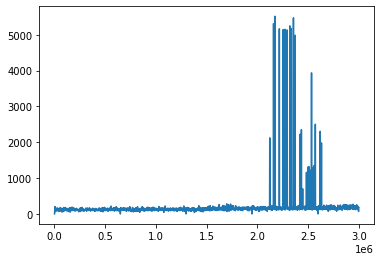

In [122]:
train_39_meats.sales.plot()

Training after replacing outliers

In [123]:
train_dates_wo_duplicates = train_wo_duplicates.drop(columns=['date'])
dates = pd.DatetimeIndex( train_wo_duplicates['date'])
train_dates_wo_duplicates['year'] = dates.year
train_dates_wo_duplicates['months'] = dates.month
train_dates_wo_duplicates['days'] = dates.day

In [124]:
train_39_meats = train_dates_wo_duplicates[(train_dates_wo_duplicates.store_nbr == 39) & (train_dates_wo_duplicates.family == 'MEATS')]

train_temp = train_39_meats.copy()
train_temp = train_temp.drop(columns=['store_nbr', 'family'])
X = train_temp.drop(columns=['sales'])
y = pd.DataFrame(train_temp['sales'])
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)
lgb.fit(X, y, verbose=False)
preds = lgb.predict(X.iloc[-16:])
preds[preds < 0] = 0
error = rmsle(y.iloc[-16:], preds, squared=False)

In [125]:
np.round(error, 2)

2.59

Error is lower after replacing outliers.

Another sample store

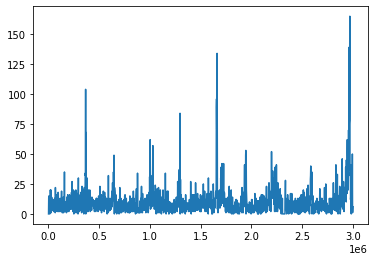

In [126]:
train_19_grocery = train_wo_duplicates[(train_wo_duplicates.store_nbr == 19) & (train_wo_duplicates.family == 'GROCERY II')]
train_19_grocery.sales.plot()

In [127]:
data = train_19_grocery[['date', 'sales']]
data.rename(columns={'date': "ds", 'sales': "y"}, inplace=True)
m, outliers = fit_predict_model(data)
outliers = detect_anomalies(outliers)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



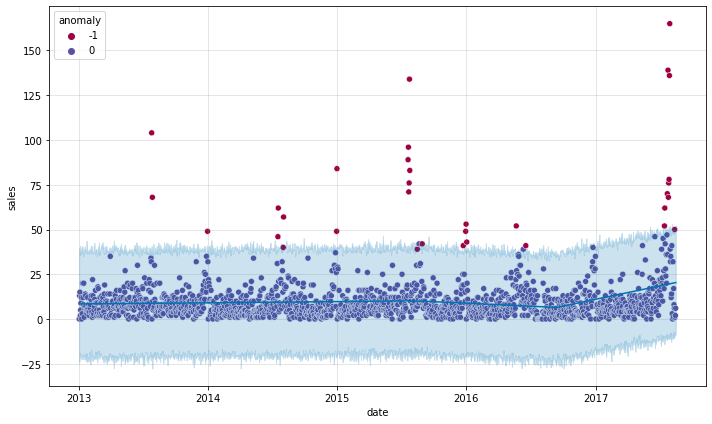

In [128]:
fig = plt.figure(facecolor='w', figsize=(10, 6))

ax = fig.add_subplot(111)

sns.scatterplot(data=outliers, x='ds', y='actual', hue='anomaly', palette="Spectral", ax=ax)
#ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.')
ax.plot(outliers.ds, outliers['yhat'], ls='-', c='#0072B2')
ax.fill_between(outliers.ds, outliers['yhat_lower'], outliers['yhat_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('sales')
fig.tight_layout()

Replacing outliers with `yhat`

In [129]:
train_19_grocery.loc[(outliers.anomaly != 0).values, 'sales'] = outliers.loc[outliers.anomaly != 0, 'yhat'].values[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



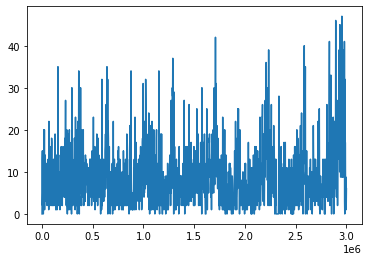

In [130]:
train_19_grocery.sales.plot()

In [131]:
train_19_grocery = train_dates_wo_duplicates[(train_dates_wo_duplicates.store_nbr == 19) & (train_dates_wo_duplicates.family == 'GROCERY II')]

train_temp = train_19_grocery.copy()
train_temp = train_temp.drop(columns=['store_nbr', 'family'])
X = train_temp.drop(columns=['sales'])
y = pd.DataFrame(train_temp['sales'])
lgb = LGBMRegressor(n_estimators=1000, max_depth=5)
lgb.fit(X, y, verbose=False)
preds = lgb.predict(X.iloc[-16:])
preds[preds < 0] = 0
error = rmsle(y.iloc[-16:], preds, squared=False)

In [132]:
np.round(error, 2)

0.8

Error remained the same after raplacing outliers.

##Training dataset without outliers and duplicates

In [133]:
train_dates_wo_duplicates = train_wo_duplicates.copy()
dates = pd.DatetimeIndex(train_wo_duplicates['date'])
train_dates_wo_duplicates['year'] = dates.year
train_dates_wo_duplicates['months'] = dates.month
train_dates_wo_duplicates['days'] = dates.day

stores = train_dates_wo_duplicates.store_nbr.unique()
families = train_dates_wo_duplicates.family.unique()

In [135]:
pd.options.mode.chained_assignment = None
SF_models = {}
errors = []

for store in tqdm(stores):
  F_models = {}

  for family in families:
    train_temp = train_dates_wo_duplicates[(train_dates_wo_duplicates.store_nbr == store) & (train_dates_wo_duplicates.family == family)]
    #replace outliers
    data = train_temp[['date', 'sales']]
    data.rename(columns={'date': "ds", 'sales': "y"}, inplace=True)
    _, outliers = fit_predict_model(data)
    outliers = detect_anomalies(outliers)

    if sum(outliers.anomaly) !=0:
      train_temp.loc[(outliers.anomaly != 0).values, 'sales'] = outliers.loc[outliers.anomaly != 0, 'yhat'].values[0]

    train_temp.drop(columns=['date'], inplace=True)
    #train LGBM
    train_temp = train_temp.drop(columns=['store_nbr', 'family'])
    X = train_temp.drop(columns=['sales'])
    y = pd.DataFrame(train_temp['sales'])
    lgb = LGBMRegressor(n_estimators=1000, max_depth=5)
    lgb.fit(X, y, verbose=False)
    F_models[family] = lgb
    preds = lgb.predict(X.iloc[-16:])
    preds[preds < 0] = 0
    #RMSLE for predicted last 16 days
    errors.append([store, family,
                   rmsle(y.iloc[-16:], preds, squared=False)])

  SF_models[store] = F_models

100%|██████████| 54/54 [50:44<00:00, 56.39s/it]


Forecasting

In [136]:
group_date = test[['date', 'family']].groupby(["date"]).count()
group_date.loc[group_date.family > 33*54]

,family
date,


In [137]:
test_dates = test.drop(columns=['date'])
dates = pd.DatetimeIndex(test['date'])
test_dates['year'] = dates.year
test_dates['months'] = dates.month
test_dates['days'] = dates.day

In [138]:
forecast = test_dates.copy()
forecast['sales'] = 0

In [139]:
for store in tqdm(stores):
  for family in families:
    data = test_dates[(test_dates.store_nbr == store) & (test_dates.family == family)].values[:, 2:]
    preds = SF_models[store][family].predict(data)
    forecast.loc[(forecast.store_nbr == store) & (forecast.family == family), 'sales'] = preds

100%|██████████| 54/54 [00:15<00:00,  3.43it/s]


In [140]:
forecast

,store_nbr,family,onpromotion,dcoilwtico,holiday,transactions,year,months,days,sales
id,,,,,,,,,,
3000888,1,AUTOMOTIVE,0,46.80,0.0,0.0,2017,8,16,-0.157665
3000889,1,BABY CARE,0,46.80,0.0,0.0,2017,8,16,0.000000
3000890,1,BEAUTY,2,46.80,0.0,0.0,2017,8,16,2.558561
3000891,1,BEVERAGES,20,46.80,0.0,0.0,2017,8,16,711.701948
3000892,1,BOOKS,0,46.80,0.0,0.0,2017,8,16,-0.106766
...,...,...,...,...,...,...,...,...,...,...
3029395,9,POULTRY,1,47.26,0.0,0.0,2017,8,31,292.202265
3029396,9,PREPARED FOODS,0,47.26,0.0,0.0,2017,8,31,76.281700
3029397,9,PRODUCE,1,47.26,0.0,0.0,2017,8,31,924.697171


In [141]:
forecast[forecast['sales'] < 0] = 0

In [142]:
forecast.sales.to_csv('lgb_wo_out&dup.csv') #

In [143]:
num_errors = [e[2] for e in errors]

In [144]:
np.mean(num_errors)

0.1546953310422811

In [145]:
np.max(num_errors)

0.9667442935569949

In [146]:
errors[np.argmax(num_errors)]

[32, 'LIQUOR,WINE,BEER', 0.9667442935569949]

In [147]:
sorted(num_errors)[-10:]

[0.6575862810911277,
 0.683424491752442,
 0.7080497141366063,
 0.718780348591699,
 0.7350779834105973,
 0.7661869701095632,
 0.8015134660273406,
 0.8446354802434108,
 0.9561715672539257,
 0.9667442935569949]

In [149]:
# import joblib
# joblib.dump(SF_models,'LGBmodels.joblib')
# joblib.dump(errors,'LGBerrors.joblib')

['LGBerrors.joblib']

#Facebook Prophet

In [150]:
train_wo_duplicates = train.groupby(["date", "store_nbr", "family"]).max().reset_index() 

In [151]:
train_temp = train_wo_duplicates[(train_wo_duplicates.store_nbr == 11) & (train_wo_duplicates.family == 'LIQUOR,WINE,BEER')]
X = train_temp[['sales', 'date']]
X.rename(columns={'date': "ds", 'sales': "y"}, inplace=True) #prophet requirement
X_train, X_val = X.iloc[:-62], X.iloc[-62:]

In [172]:
m = Prophet()#weekly_seasonality = True)
m.fit(X_train)  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
future = m.make_future_dataframe(periods=62)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1679,2017-08-11,69.452708,-0.300890,137.502300
1680,2017-08-12,88.326731,20.260179,159.960881
1681,2017-08-13,10.919084,-49.838577,82.712051
1682,2017-08-14,27.319107,-43.124683,100.533457
1683,2017-08-15,29.434559,-33.855924,92.184230


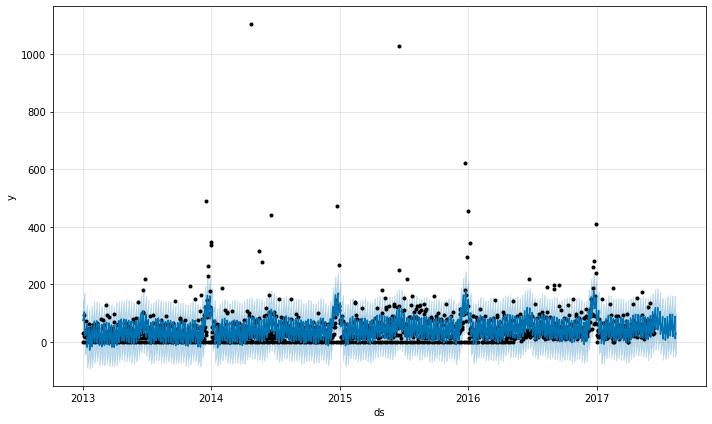

In [174]:
fig1 = m.plot(forecast)

In [175]:
plot_plotly(m, forecast)

In [176]:
plot_components_plotly(m, forecast)

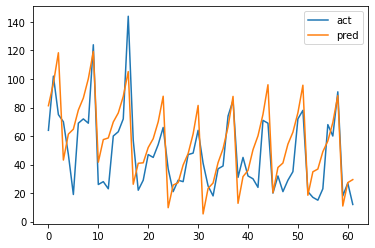

In [188]:
pred_df = pd.DataFrame({'act': X_val['y'].values, 'pred': forecast['yhat'][-62:].values})
pred_df.plot()

In [189]:
rmsle(X_val['y'], forecast['yhat'][-62:], squared=False)

0.5202735955808027

In [ ]:
# playoffs = pd.DataFrame({
#   'holiday': 'playoff',
#   'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                         '2010-01-24', '2010-02-07', '2011-01-08',
#                         '2013-01-12', '2014-01-12', '2014-01-19',
#                         '2014-02-02', '2015-01-11', '2016-01-17',
#                         '2016-01-24', '2016-02-07']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# superbowls = pd.DataFrame({
#   'holiday': 'superbowl',
#   'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# holidays = pd.concat((playoffs, superbowls))

# m = Prophet(holidays=holidays)
# forecast = m.fit(df).predict(future)


In [ ]:
#https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
#https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events
#https://facebook.github.io/prophet/docs/non-daily_data.html#sub-daily-data